In [1]:
import argparse
import os,sys
import numpy as np
import math

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision.transforms import ToTensor, Lambda

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'torchvision'

In [ ]:
# Setup device-agnostic code 
if torch.cuda.is_available():
    device = "cuda" # NVIDIA GPU
elif torch.backends.mps.is_available():
    device = "mps" # Apple GPU
else:
    device = "cpu"

print(device)

cuda


In [ ]:
n_epochs = 200
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu = 8
latent_dim = 100
img_size = 28
channels = 1
sample_interval = 400

In [ ]:
import pandas as pd
import os

from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

class ChineseMNISTDataset(Dataset):
    def __init__(self, transform=None, target_transform=None):
        self.img_labels = pd.read_csv('../data/chinese_mnist/chinese_mnist.csv')
        self.img_dir = '../data/chinese_mnist/data/data'
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        suite_id,sample_id,code,value, _ = self.img_labels.iloc[idx]
        img_name = 'input_{0}_{1}_{2}.jpg'.format(suite_id,sample_id, code)
        img_path = os.path.join(self.img_dir, img_name)
        image = read_image(img_path)
        label = code
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


In [ ]:

os.makedirs("images", exist_ok=True)

img_shape = (channels, img_size, img_size)

cuda = True if torch.cuda.is_available() else False
mps = True if torch.backends.mps.is_available() else False


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [ ]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()


transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
                                
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

if mps:
    generator.to(device)
    discriminator.to(device)
    adversarial_loss.to(device)


# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

train_data = datasets.MNIST(
    root='../data/mnist',
    train=True,
    transform=transform, 
    #把灰階從0~255壓縮到0~1
    download=True
)

# Configure data loader
dataloader = torch.utils.data.DataLoader(
    train_data,
    batch_size= batch_size,
    shuffle=True,
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw



Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


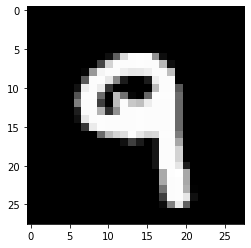

Label: 9


In [ ]:
# Display image and label.
train_features, train_labels = next(iter(dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")


In [ ]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

<class 'torch.cuda.FloatTensor'>


In [ ]:
# ----------
#  Training
# ----------

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

   

        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)


[Epoch 0/200] [Batch 0/938] [D loss: 0.676615] [G loss: 0.684211]
[Epoch 0/200] [Batch 400/938] [D loss: 0.482688] [G loss: 1.364252]
[Epoch 0/200] [Batch 800/938] [D loss: 0.306489] [G loss: 1.170106]
[Epoch 1/200] [Batch 262/938] [D loss: 0.312005] [G loss: 1.120803]
[Epoch 1/200] [Batch 662/938] [D loss: 0.394343] [G loss: 0.839699]
[Epoch 2/200] [Batch 124/938] [D loss: 0.407498] [G loss: 2.018535]
[Epoch 2/200] [Batch 524/938] [D loss: 0.248315] [G loss: 1.404634]
[Epoch 2/200] [Batch 924/938] [D loss: 0.256685] [G loss: 1.992788]
[Epoch 3/200] [Batch 386/938] [D loss: 0.270193] [G loss: 1.487350]
[Epoch 3/200] [Batch 786/938] [D loss: 0.275694] [G loss: 2.323223]
[Epoch 4/200] [Batch 248/938] [D loss: 0.314252] [G loss: 0.969759]
[Epoch 4/200] [Batch 648/938] [D loss: 0.270192] [G loss: 1.673435]
[Epoch 5/200] [Batch 110/938] [D loss: 0.368411] [G loss: 4.186116]
[Epoch 5/200] [Batch 510/938] [D loss: 0.229779] [G loss: 2.194354]
[Epoch 5/200] [Batch 910/938] [D loss: 0.487962] [